1.** Introduction**

Diabetes is a chronic medical condition affecting millions worldwide. Early diagnosis and prediction are crucial for managing this disease. In this project, we will use patient data including demographics and lab results to build a machine learning model that predicts the likelihood of diabetes.

We'll go through the full machine learning pipeline:

1. Data loading and exploration
2.  Data cleaning and preprocessing
3.  Model building and evaluation
4.  Feature importance analysis

2. Importing Libraries

In [1]:
# Data manipulation
library(dplyr)
library(tidyr)

# Data handling
library(readr)

# Visualization
library(ggplot2)
library(GGally)
library(corrplot)

# Train/test split and model tuning
library(caret)

# Random Forest
library(randomForest)

# Evaluation metrics
library(caret)   # also covers confusionMatrix, accuracy, classification report-like output

# Preprocessing (Label Encoding, Scaling)
  # dummyVars (label encoding), preProcess (scaling)
library(xgboost)

library(e1071)


Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



corrplot 0.92 loaded



Loading required package: lattice




Attaching package: ‘caret’




The following object is masked from ‘package:httr’:

    progress




randomForest 4.7-1.1



Type rfNews() to see new features/changes/bug fixes.




Attaching package: ‘randomForest’




The following object is masked from ‘package:ggplot2’:

    margin




The following object is masked from ‘package:dplyr’:

    combine





Attaching package: ‘xgboost’




The following object is masked from ‘package:dplyr’:

    slice




**3. Importing dataset**

In [2]:
# Load dataset
df <- read.csv("/kaggle/input/diabetes/diabetic_data.csv")

# Display basic info
head(df)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,⋯,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,⋯,No,No,No,No,No,No,No,No,No,NO
2,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,⋯,No,Up,No,No,No,No,No,Ch,Yes,>30
3,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,⋯,No,No,No,No,No,No,No,No,Yes,NO
4,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,⋯,No,Up,No,No,No,No,No,Ch,Yes,NO
5,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,⋯,No,Steady,No,No,No,No,No,Ch,Yes,NO
6,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,⋯,No,Steady,No,No,No,No,No,No,Yes,>30


4. Data Analyse and Data Cleaning

In [3]:
# Check missing values
missing <- colSums(is.na(df))
missing[missing > 0][order(-missing[missing > 0])]

# Drop columns with too many missing or irrelevant values
df <- subset(df, select = -c(weight, payer_code, medical_specialty, encounter_id, patient_nbr))

# Drop duplicates if any
df <- df[!duplicated(df), ]

# Check class distribution
table(df$readmitted)


named numeric(0)


  <30   >30    NO 
11357 35545 54864 

**5.Feature Engineering**

In [4]:
# Simplify 'readmitted' to binary target
df$readmitted <- ifelse(df$readmitted == "<30", 1, 0)

# Encode categorical features
cat_cols <- names(df)[sapply(df, is.character)]

for (col in cat_cols) {
  df[[col]] <- as.integer(as.factor(df[[col]]))
}


6. **Data Splitting**

In [5]:
# Split into features and target
X <- subset(df, select = -readmitted)
y <- df$readmitted

# Train-test split (80% train, 20% test)
set.seed(42)
train_index <- sample(seq_len(nrow(df)), size = 0.8 * nrow(df))

X_train <- X[train_index, ]
X_test  <- X[-train_index, ]
y_train <- y[train_index]
y_test  <- y[-train_index]


7. **Model Training and Evaluating**

In [6]:


# Train Random Forest model (with class weights)
# Compute class weights inversely proportional to frequency
class_weights <- table(y_train)
class_weights <- as.numeric(sum(class_weights)) / (length(class_weights) * class_weights)

rf <- randomForest(
  x = X_train, 
  y = as.factor(y_train), 
  ntree = 100,
  strata = y_train,
  sampsize = rep(min(table(y_train)), 2), # balance sampling
  importance = TRUE
)

# Predict
y_pred <- predict(rf, X_test)

# Evaluation
accuracy <- mean(y_pred == y_test)
cat("Random Forest Accuracy:", accuracy, "\n")

# Confusion matrix
conf_mat <- confusionMatrix(as.factor(y_pred), as.factor(y_test))
print(conf_mat)

# Classification report (precision, recall, F1)
print(conf_mat$byClass)   # per-class metrics
print(conf_mat$overall)   # overall accuracy, Kappa, etc.


Random Forest Accuracy: 0.7827454 


Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 15170  1515
         1  2907   762
                                         
               Accuracy : 0.7827         
                 95% CI : (0.777, 0.7884)
    No Information Rate : 0.8881         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1372         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.8392         
            Specificity : 0.3347         
         Pos Pred Value : 0.9092         
         Neg Pred Value : 0.2077         
             Prevalence : 0.8881         
         Detection Rate : 0.7453         
   Detection Prevalence : 0.8197         
      Balanced Accuracy : 0.5869         
                                         
       'Positive' Class : 0              
                                      

         Sensitivity          Specificity       Pos Pred Value 
           0.8391879            0.3346509            0.9091999 
      Neg Pred Value            Precision               Recall 
           0.2076860            0.9091999            0.8391879 
                  F1           Prevalence       Detection Rate 
           0.8727921            0.8881301            0.7453080 
Detection Prevalence    Balanced Accuracy 
           0.8197406            0.5869194 


      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
  7.827454e-01   1.371873e-01   7.770154e-01   7.883945e-01   8.881301e-01 
AccuracyPValue  McnemarPValue 
  1.000000e+00   3.680834e-97 


**8. Feature Importance Evaluation**

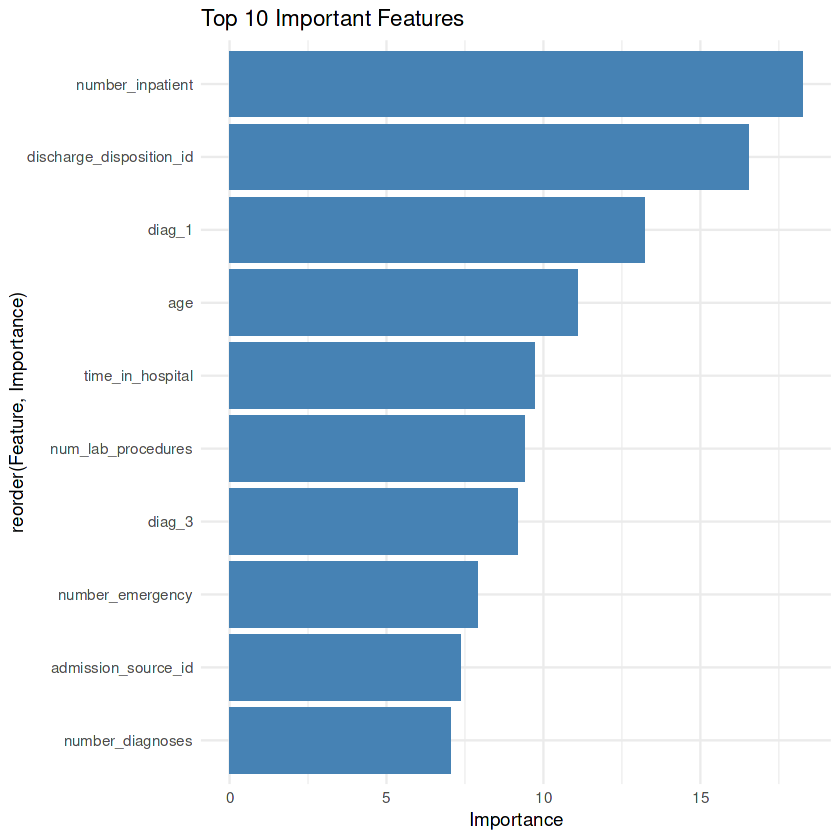

In [7]:
# Feature importance
importances <- importance(rf)
indices <- order(importances[, 1], decreasing = TRUE)
features <- colnames(X_train)

# Plot
library(ggplot2)
top_features <- data.frame(
  Feature = features[indices][1:10],
  Importance = importances[indices, 1][1:10]
)

ggplot(top_features, aes(x = Importance, y = reorder(Feature, Importance))) +
  geom_bar(stat = "identity", fill = "steelblue") +
  ggtitle("Top 10 Important Features") +
  theme_minimal()


**9. Conclusion**

This project demonstrated the potential of machine learning in medical diagnosis. Our Random Forest classifier performed reasonably well in identifying patients at high risk of readmission due to diabetes.

Future work may include:

1.Trying different models (XGBoost, SVM)
2.Hyperparameter tuning
3.Handling class imbalance (SMOTE)
4.Integrating time-based features or external health data
This workflow can be adapted for many engineering applications involving predictive modeling.